In [29]:
# Import 需要的套件
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

參考： https://medium.com/@peilee_98185/%E9%A1%A7%E5%AE%A2%E5%83%B9%E5%80%BC%E5%88%86%E6%9E%90-buy-till-you-die-with-python-9f911b5b3e97

先下載 lifetimes套件

In [30]:
# pip install lifetimes

from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *
from lifetimes import *
%matplotlib inline

In [31]:
al = pd.read_csv('./al.csv')

In [32]:
al = al.loc[al.sup_name!='團購']
al = al.loc[al.orders_dt < '2018-11-01']

base = al[['member_id','orders_dt','total_price']]

# base.sort_values('orders_dt',ascending=False)

In [33]:
# base = base.groupby(['member_id' , 'orders_dt']).total_price.sum()

# base = pd.DataFrame(base).reset_index()

# base.to_csv('./base.csv')

In [34]:
# al.loc[al.member_id == 50502].sort_values('orders_dt').tail(8)

In [35]:
data = summary_data_from_transaction_data(base, 'member_id', 'orders_dt',observation_period_end = '2018-10-31')
data.head()

,frequency,recency,T
member_id,,,
5,0.0,0.0,706.0
12,2.0,375.0,671.0
35,0.0,0.0,744.0
46,0.0,0.0,359.0
56,2.0,317.0,609.0


In [36]:
base.shape ,data.shape

((97414, 3), (47021, 3))

In [37]:
base.loc[base.member_id == 50502].sort_values('orders_dt')

,member_id,orders_dt,total_price
24744,50502,2017-12-21,1390
66885,50502,2018-01-26,109
66886,50502,2018-01-26,104
66887,50502,2018-01-26,369
66888,50502,2018-01-26,109
66889,50502,2018-01-26,109
110923,50502,2018-05-31,349
110924,50502,2018-05-31,105
110925,50502,2018-05-31,60
110926,50502,2018-05-31,55


count    47021.000
mean         0.151
std          0.596
min          0.000
25%          0.000
50%          0.000
75%          0.000
max         44.000
Name: frequency, dtype: float64
0.8946640862593309


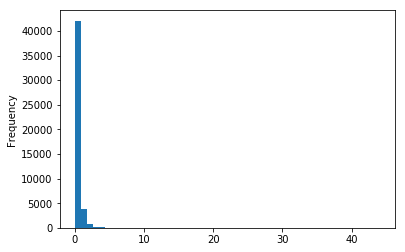

In [38]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

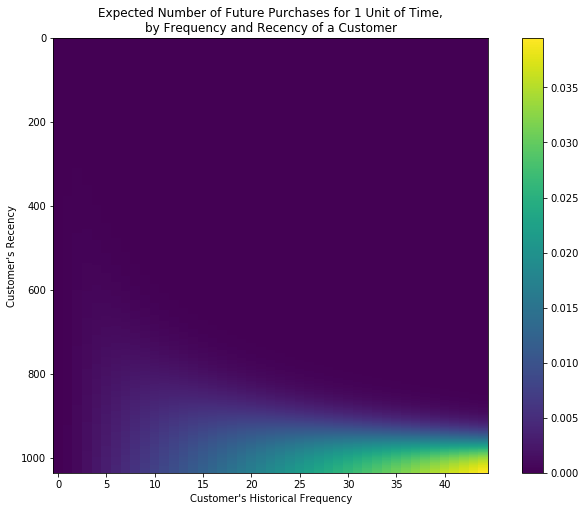

In [39]:
import matplotlib.pyplot as plt

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

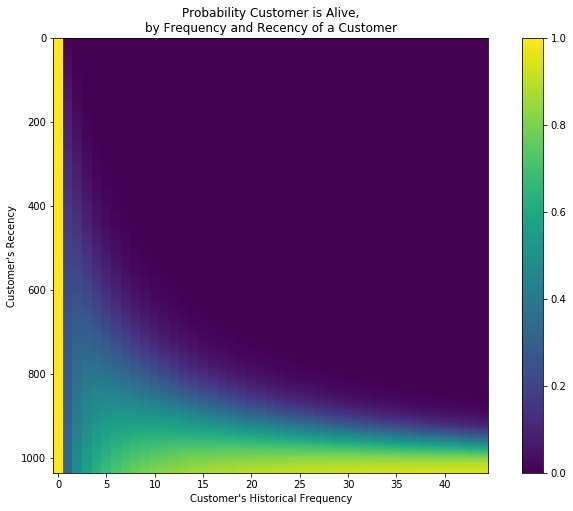

In [40]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [41]:
np.set_printoptions(suppress=True) 
t = 60
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                              data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
member_id,,,,
61766,8.0,126.0,162.0,0.751
36373,11.0,573.0,574.0,0.831
46281,11.0,330.0,366.0,0.912
42630,16.0,410.0,429.0,1.449
35506,44.0,590.0,604.0,3.321


In [42]:
#predicted_purchases： 預期購買數
pd.set_option('display.precision',3)
predicted_purchases = data.sort_values(by='predicted_purchases', ascending=False).reset_index()

In [57]:
# np.set_printoptions(suppress=True)
print(predicted_purchases.shape)
predicted_purchases.head(7)

(47021, 5)


,member_id,frequency,recency,T,predicted_purchases
0,35506,44.0,590.0,604.0,3.321
1,42630,16.0,410.0,429.0,1.449
2,46281,11.0,330.0,366.0,0.912
3,36373,11.0,573.0,574.0,0.831
4,61766,8.0,126.0,162.0,0.751
5,36504,11.0,540.0,569.0,0.743
6,66070,3.0,66.0,72.0,0.698


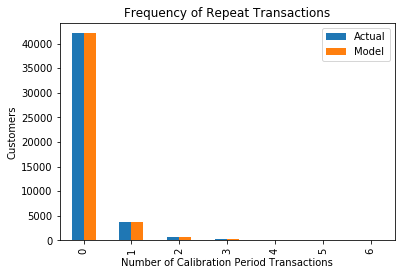

In [44]:
plot_period_transactions(bgf)

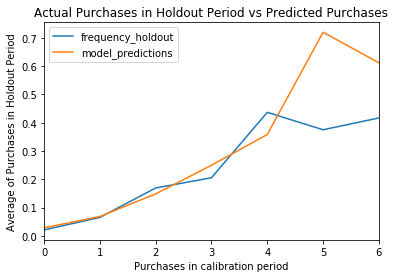

In [45]:
summary_cal_holdout = calibration_and_holdout_data(base, 'member_id', 'orders_dt',
                                calibration_period_end='2018-04-30',observation_period_end='2018-10-31' )

bgf.fit(summary_cal_holdout['frequency_cal'],   
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [59]:
# old = pd.read_csv('./old.csv')

p1 = predicted_purchases.head(1000)

pd.merge(p1,old, on = 'member_id' ,how='left').target.value_counts()

0    788
1    212
Name: target, dtype: int64

In [ ]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))

days_since_birth = 92

sp_trans = base.loc[base['member_id'] == 82001]

plot_history_alive(bgf,days_since_birth,sp_trans, 'orders_dt')

### 客戶價值估算

In [19]:
data2 = summary_data_from_transaction_data(base, 'member_id', 'orders_dt', 
                              monetary_value_col='total_price', observation_period_end='2018-10-31')

In [20]:
returning_customers_summary = data2[ (data2['frequency'] > 0) & 
                                     (data2['monetary_value'] != 0)]

In [21]:
#每個顧客未來單次購買可能的金額
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

predicted_unitprice = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                returning_customers_summary['monetary_value'])

In [22]:
predicted_unitprice = pd.DataFrame(predicted_unitprice).reset_index()

In [23]:
predicted_unitprice.columns = ['member_id','predicted_unitprice']
predicted_unitprice.head(5)

,member_id,predicted_unitprice
0,12,1351.849
1,56,595.520
2,57,1483.306
3,59,1687.619
4,98,1078.268


In [24]:
true = base.loc[base.orders_dt > '2018-12-23']
true = true.groupby(['member_id' , 'orders_dt']).total_price.sum()

true = pd.DataFrame(true).reset_index()

In [28]:
merge = pd.merge(true,predicted_unitprice,on = 'member_id', how = 'inner')

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(merge.total_price, merge.predicted_unitprice)

49.59502200827294

In [27]:
from sklearn import metrics, datasets

mae = metrics.mean_absolute_error(merge.predicted_unitprice, merge.total_price) # 使用 MAE 評估

mse = metrics.mean_squared_error(merge.predicted_unitprice, merge.total_price) # 使用 MSE 評估

r2 = metrics.r2_score(merge.predicted_unitprice, merge.total_price) # 使用 r-square 評估

print("MAE: ", mae)
print("MSE: ", mse)
print("R-square: ", r2)

MAE:  947.6817819234146
MSE:  10114610.919631826
R-square:  -2.5243653489721467
